# view-SEsystem-LET-ballistic

Yuri Shimane, 2021/07/06

In [1]:
using LinearAlgebra
using JSON
using Plots
using DifferentialEquations

In [21]:
gr()

Plots.GRBackend()

In [3]:
include("../R3BP/src/R3BP.jl")

Main.R3BP

In [4]:
params = R3BP.get_cr3bp_param(10, 399)
mu = params.mu
println("mu: $mu")
lp = R3BP.lagrangePoints(mu)

mu: 3.003480593992992e-6


5×6 Matrix{Float64}:
  0.990027   0.0       0.0  0.0  0.0  0.0
  1.01003    0.0       0.0  0.0  0.0  0.0
 -1.0        0.0       0.0  0.0  0.0  0.0
  0.499997   0.866025  0.0  0.0  0.0  0.0
  0.499997  -0.866025  0.0  0.0  0.0  0.0

In [5]:
reltol = 1.0e-13
abstol = 1.0e-13

1.0e-13

In [29]:
readdir("./let-SunEarthSystem-data/")

8-element Vector{String}:
 "se_ballistic_20210706_1028.json"
 "se_ballistic_20210706_1049.json"
 "se_ballistic_20210706_1102.json"
 "se_ballistic_20210706_1436.json"
 "se_ballistic_20210706_1737.json"
 "se_ballistic_20210706_1930.json"
 "se_ballistic_20210706_2319.json"
 "se_enhanced_20210706_2324.json"

In [30]:
outs = JSON.parsefile("./let-SunEarthSystem-data/se_ballistic_20210706_2319.json");

In [31]:
# constructing ODE problem
x0 = vcat([el for el in outs[1]["x0"]], 1.0)
tspan = (0.0, 2.0*outs[1]["tf"])
#p = (mu)
#prob = ODEProblem(R3BP.rhs_pcr3bp_sv!, x0, tspan, p)

τ = 0.0
mdot = 1.0e-5
tmax = 1.0e-2
p = (mu, τ, mdot, tmax)
prob = ODEProblem(R3BP.rhs_pcr3bp_thrust_m1dir!, x0, tspan, p)
sol = solve(prob, Tsit5(), reltol=reltol, abstol=abstol);

In [32]:
# construct initial guess from data
x0s, tfs = [], []
for out in outs
    push!(x0s, [el for el in out["x0"]])
    push!(tfs, out["tf"])
end
nic = length(x0s)
println("Using $nic solutions")

Using 8 solutions


In [33]:
function check_apsis(sv, mu, m=2)
    if m == 2
        x = sv[1] - (1-mu)
    end
    return dot([x, sv[2]], sv[3:4])
end

# event based on having perigee around 0.9~1.1 * sma of the moon
moon_sma = 384748.0 / params.lstar
function condition(u,t,integrator)
    r_local = sqrt((u[1] - (1-mu))^2 + u[2]^2)
    if 0.9moon_sma < r_local < 1.1moon_sma
        return check_apsis(u, mu)    # when hitting apsis
    else
        return NaN
    end
end

affect!(integrator) = terminate!(integrator)

# assign callback
cb = ContinuousCallback(condition,affect!);

In [34]:
# ---------- ensemble simulation ---------- #
function prob_func(prob, i, repeat)
    print("\ri: $i out of $nic")
    remake(prob, u0=vcat(x0s[i], 1.0), tspan=(0.0, 2.0tfs[i]))
end

ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
sim = solve(ensemble_prob, Tsit5(), EnsembleThreads(), trajectories=length(x0s), callback=cb, 
    reltol=reltol, abstol=abstol);

i: 8 out of 8

In [35]:
function plot_circle(radius, x, y, n=50)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

function list_to_plotarray_3d(sollist, state_idx_x, state_idx_y, state_idx_z)
    x_plot, y_plot, z_plot = [], [], []
    for k = 1:length(sollist)
        push!(x_plot, sollist[k][state_idx_x])
        push!(y_plot, sollist[k][state_idx_y])
        push!(z_plot, sollist[k][state_idx_z])
    end
    return x_plot, y_plot, z_plot
end

list_to_plotarray_3d (generic function with 1 method)

In [36]:
# get moon orbit for plotting
moon_sma = 384748.0 / params.lstar
moon_orbit = plot_circle(moon_sma, 1.0-mu, 0.0)

2×50 Matrix{Float64}:
 1.00257  1.00255     1.00248     1.00238      …   1.00255      1.00257
 0.0      0.00032888  0.00065236  0.000965129     -0.00032888  -6.2992e-19

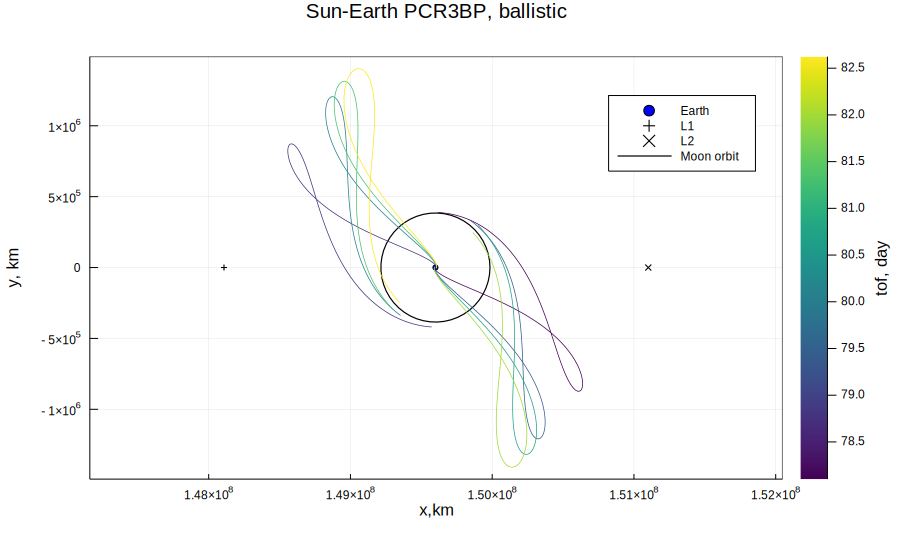

In [38]:
ptest = plot(flip=false, aspect_ratio=:equal, size=(900, 550), title="Sun-Earth PCR3BP, ballistic", 
             colorbar_title="tof, day", xlabel="x,km", ylabel="y, km", frame_style=:box)
scale = params.lstar

# Earth
scatter!(ptest, [1.0-mu]*scale, [0.0]*scale, marker=(:circle, 4.5, 3.0), c=:blue, label="Earth")

# Lagrange-points
scatter!(ptest, [lp[1,1]*scale], [lp[1,2]], marker=(:cross, 2.5, 3.0), c=:black, label="L1")
scatter!(ptest, [lp[2,1]*scale], [lp[2,2]], marker=(:xcross, 2.5, 3.0), c=:black, label="L2")

# moon orbit
plot!(ptest, moon_orbit[1,:]*scale, moon_orbit[2,:]*scale, c=:black, lw=1.2, label="Moon orbit")

# color map for trajectory
tofs = []
for sol in sim
    push!(tofs, sol.t[end]*params.tstar/86400.0)
end
segc = LinRange(minimum(tofs), maximum(tofs), length(sim))

# propagated trajectories
n_terminated = 0
for (idx,sol) in enumerate(sim)
    x_plot, y_plot, _ = list_to_plotarray_3d(sol, 1,2,3)
    #plot!(ptest, x_plot*scale, y_plot*scale, c=:orangered, label=false, lw=0.75)
    plot!(ptest, x_plot*scale, y_plot*scale, line_z=segc[idx], c=cgrad(:viridis), label=false, lw=0.75)
end
ptest